In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
data = pd.read_csv('./csv/option4.csv')

# Обзор данных
print("Количество колонок:", data.columns.size)
print("Колонки:", data.columns)

Количество колонок: 12
Колонки: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [100]:
print("\nНаличие пропущенных значений:")
print(data.isnull().sum())

print("\n\n")

print(data.describe)


Наличие пропущенных значений:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64



<bound method NDFrame.describe of          id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0            

<p style="margin: 30px;">Возьмем и заменим нулевые значения в столбце bmi на средние значения по столбцу </p>

In [101]:
data['bmi'] = data['bmi'].fillna(data['bmi'].median())
print("\nНаличие пропущенных значений:")
print(data.isnull().sum())


Наличие пропущенных значений:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


<p style="margin: 30px;">Взглянем на выбросы: </p>

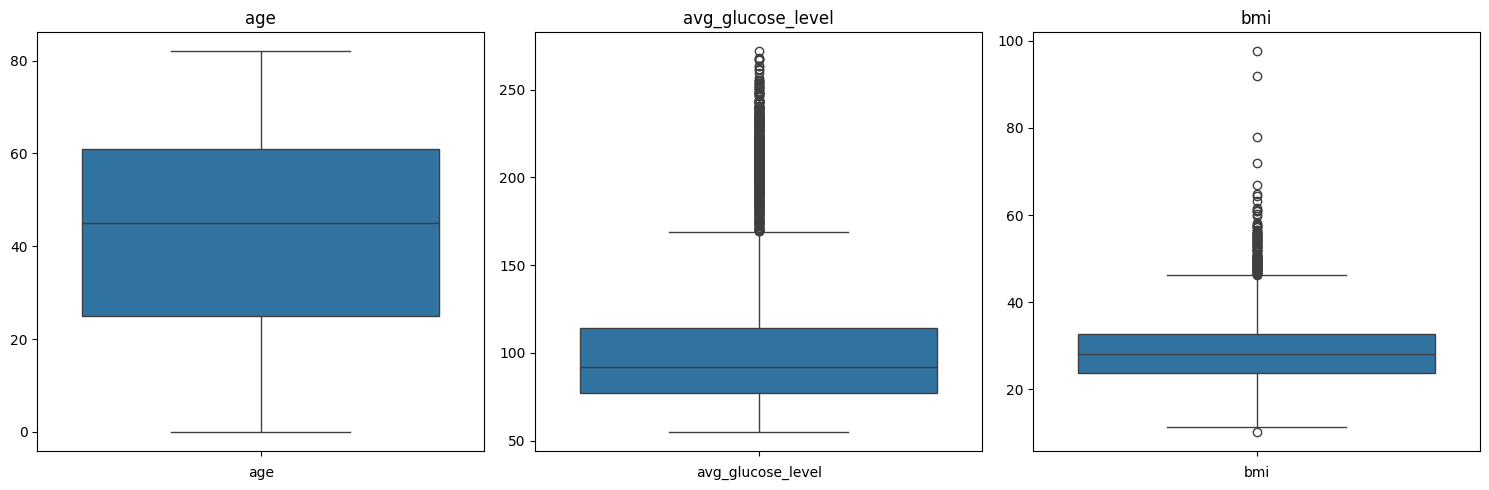

In [102]:
def plot_numeric_boxplots(dataframe, columns):
    # Фильтрация числовых столбцов
    numeric_columns = ['age', 'avg_glucose_level', 'bmi']
    
    # Построение графиков
    if numeric_columns:
        plt.figure(figsize=(15, 5))
        
        for i, col in enumerate(numeric_columns):
            if col != 'id':
                  plt.subplot(1, len(numeric_columns), i + 1)
                  sns.boxplot(y=dataframe[col])
                  plt.title(f'{col}')
                  plt.ylabel('')
                  plt.xlabel(col)
                          
        plt.tight_layout()
        plt.show()
    else:
        print("Нет подходящих числовых столбцов для построения графиков.")

plot_numeric_boxplots(data, data.columns)

<p style="margin: 30px;">Видим выбросы в столбцах со средним уровнем глюкозы и в столбце bmi (индекс массы тела). устраним выбросы - поставим верхние и нижние границы</p>

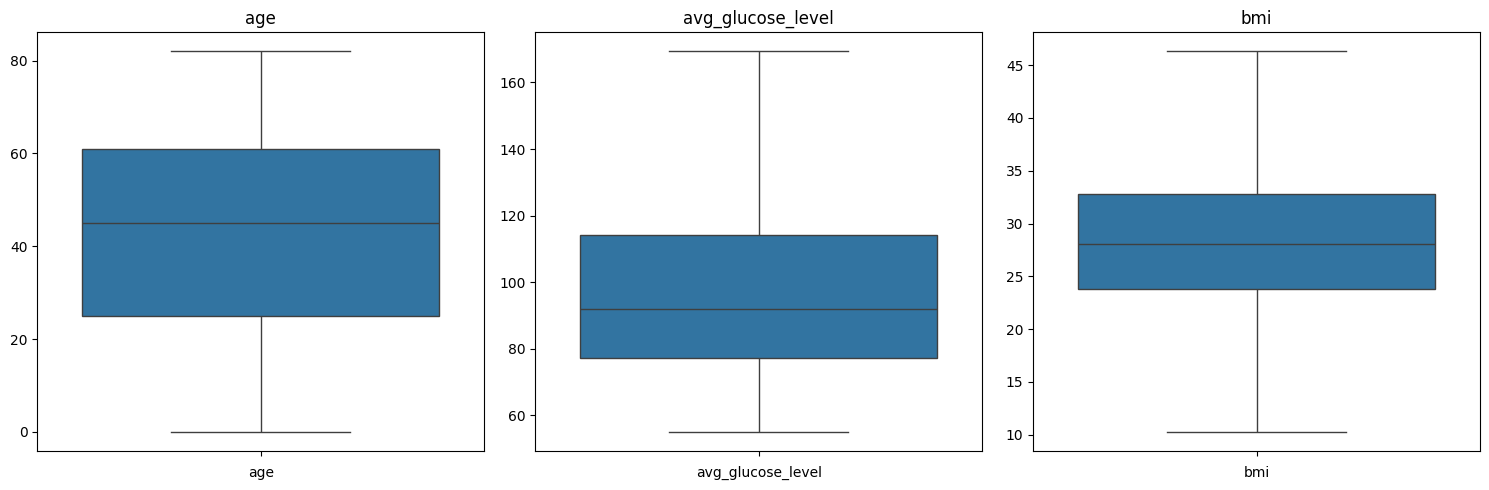

In [104]:
def remove_outliers(df):

    numeric_columns = ['age', 'avg_glucose_level', 'bmi']
    for column in numeric_columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df
    
data = remove_outliers(data)
plot_numeric_boxplots(data, data.columns)

<p style="margin: 30px;">Так, от выбросов избавились, теперь разобьем на выборки</p>

In [107]:
from sklearn.model_selection import train_test_split

# Определение признаков и целевой переменной
X = data.drop(columns=['id', 'stroke'])  
y = data['stroke']  

# Обучающая выборка
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Тестовая и контрольная выборки
X_test, X_control, y_test, y_control = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("\nРазмеры выборок:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Контрольная выборка: {X_control.shape}")


Размеры выборок:
Обучающая выборка: (4088, 10)
Тестовая выборка: (511, 10)
Контрольная выборка: (511, 10)


stroke
0    4861
1     249
Name: count, dtype: int64


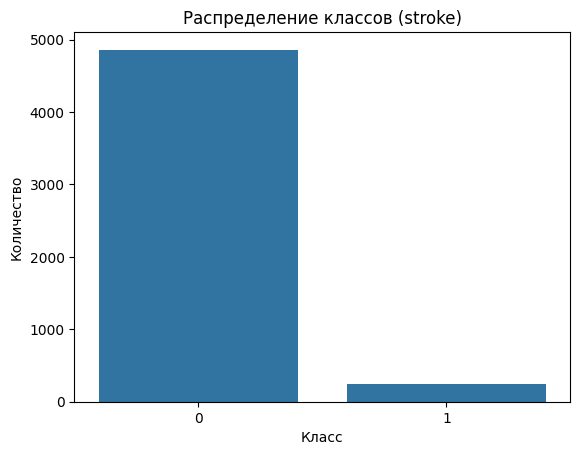

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Подсчет количества объектов каждого класса
class_counts = y.value_counts()
print(class_counts)

# Визуализация
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Распределение классов (stroke)")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()


<p style="margin: 30px;">Напишем функцию и сделаем аугментацию данных</p>

Данные ДО аугментации в ОБУЧАЮЩЕЙ ВЫБОРКЕ  (60-80% данных)

stroke
0    3889
1     199
Name: count, dtype: int64

После оверсемплинга

stroke
0    3889
1    1944
Name: count, dtype: int64

После балансировки данных (андерсемплинга)

stroke
0    1944
1    1944
Name: count, dtype: int64


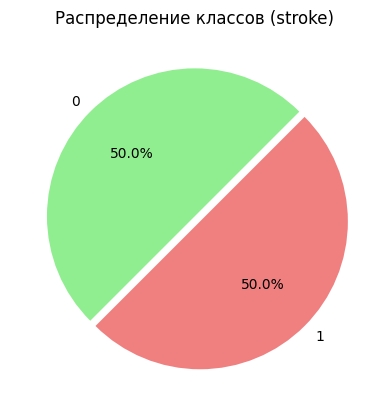

Данные ДО аугментации в ТЕСТОВОЙ ВЫБОРКЕ  (10-20% данных)

stroke
0    486
1     25
Name: count, dtype: int64

После оверсемплинга

stroke
0    486
1    243
Name: count, dtype: int64

После балансировки данных (андерсемплинга)

stroke
0    243
1    243
Name: count, dtype: int64


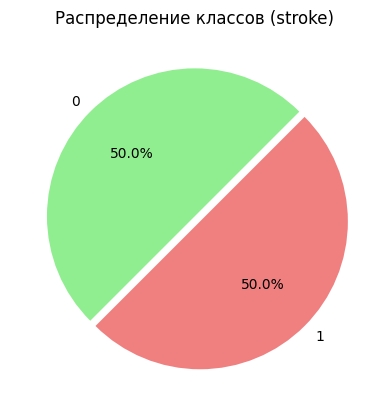

In [114]:

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def over_under_sampling(x_selection, y_selection):

    # сначала увеличение меньшинства

    oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42) 
    x_over, y_over = oversampler.fit_resample(x_selection, y_selection) 

    print("\nПосле оверсемплинга\n")
    print(y_over.value_counts())

    # потом уменьшение большинства

    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    x_balanced, y_balanced = undersampler.fit_resample(x_over, y_over)

    print("\nПосле балансировки данных (андерсемплинга)\n")
    print(y_balanced.value_counts())

    plt.pie(
    y_balanced.value_counts(), 
    labels=class_counts.index,  # Метки классов (0 и 1)
    autopct='%1.1f%%',  # Отображение процентов
    colors=['lightgreen', 'lightcoral'],  # Цвета для классов
    startangle=45,  # Поворот диаграммы
    explode=(0, 0.05)  # Небольшое смещение для класса 1
    )
    plt.title("Распределение классов (stroke)")
    plt.show()

print("Данные ДО аугментации в ОБУЧАЮЩЕЙ ВЫБОРКЕ  (60-80% данных)\n")
print(y_train.value_counts())
over_under_sampling(X_train, y_train)

print("Данные ДО аугментации в ТЕСТОВОЙ ВЫБОРКЕ  (10-20% данных)\n")
print(y_test.value_counts())
over_under_sampling(X_test, y_test)

<p style="margin: 30px;">Теперь можно и к конструированию признаков приступить) данные ведь сбалансированы (в выборках)</p>

<p style="margin: 30px;">Унитарное кодирование категориальных признаков <br/> <br/>Применяем к категориальным (НЕ числовым) признакам: 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'</p>

In [ ]:
# One-Hot Encoding
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)

print("Данные после унитарного кодирования:")
print(X_encoded.head())
